In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import model_utils
import plot_utils
import custom_transforms
from dataset import COCO_Person_Dataset
from nn_model import Net
from CONSTANTS import idx_to_keypoint_type
from custom_transforms import *
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import time

In [17]:
#17 keypoints
#'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 
#'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 
#'right_knee', 'left_ankle', 'right_ankle'


In [2]:
processed_files = {
    'img_id_to_annotations': 'img_id_to_annotations.npy',
    'img_id_to_image_info' : 'img_id_to_image_info.npy',
    'im_ids' : 'im_ids.npy'
}

In [3]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)

tfms = transforms.Compose([
    RandomCrop(),
    ResizeImgAndKeypoints(368),
    ColorJitter(),
    RandomGrayscale(),
    FlipHR(),
    FlipUD(),
    RandomRotateImgAndKeypoints(deg=20)
])

tensor_tfms = transforms.Compose([
    ToTensor(),
    NormalizeImg(mean, std)
])

un = UnNormalizeImgBatch(mean, std)
p = transforms.ToPILImage()

In [17]:
To_Pil = transforms.ToPILImage()

In [4]:
bs = 8
ds = COCO_Person_Dataset('train2014/', processed_files, tfms, tensor_tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

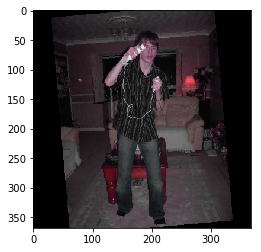

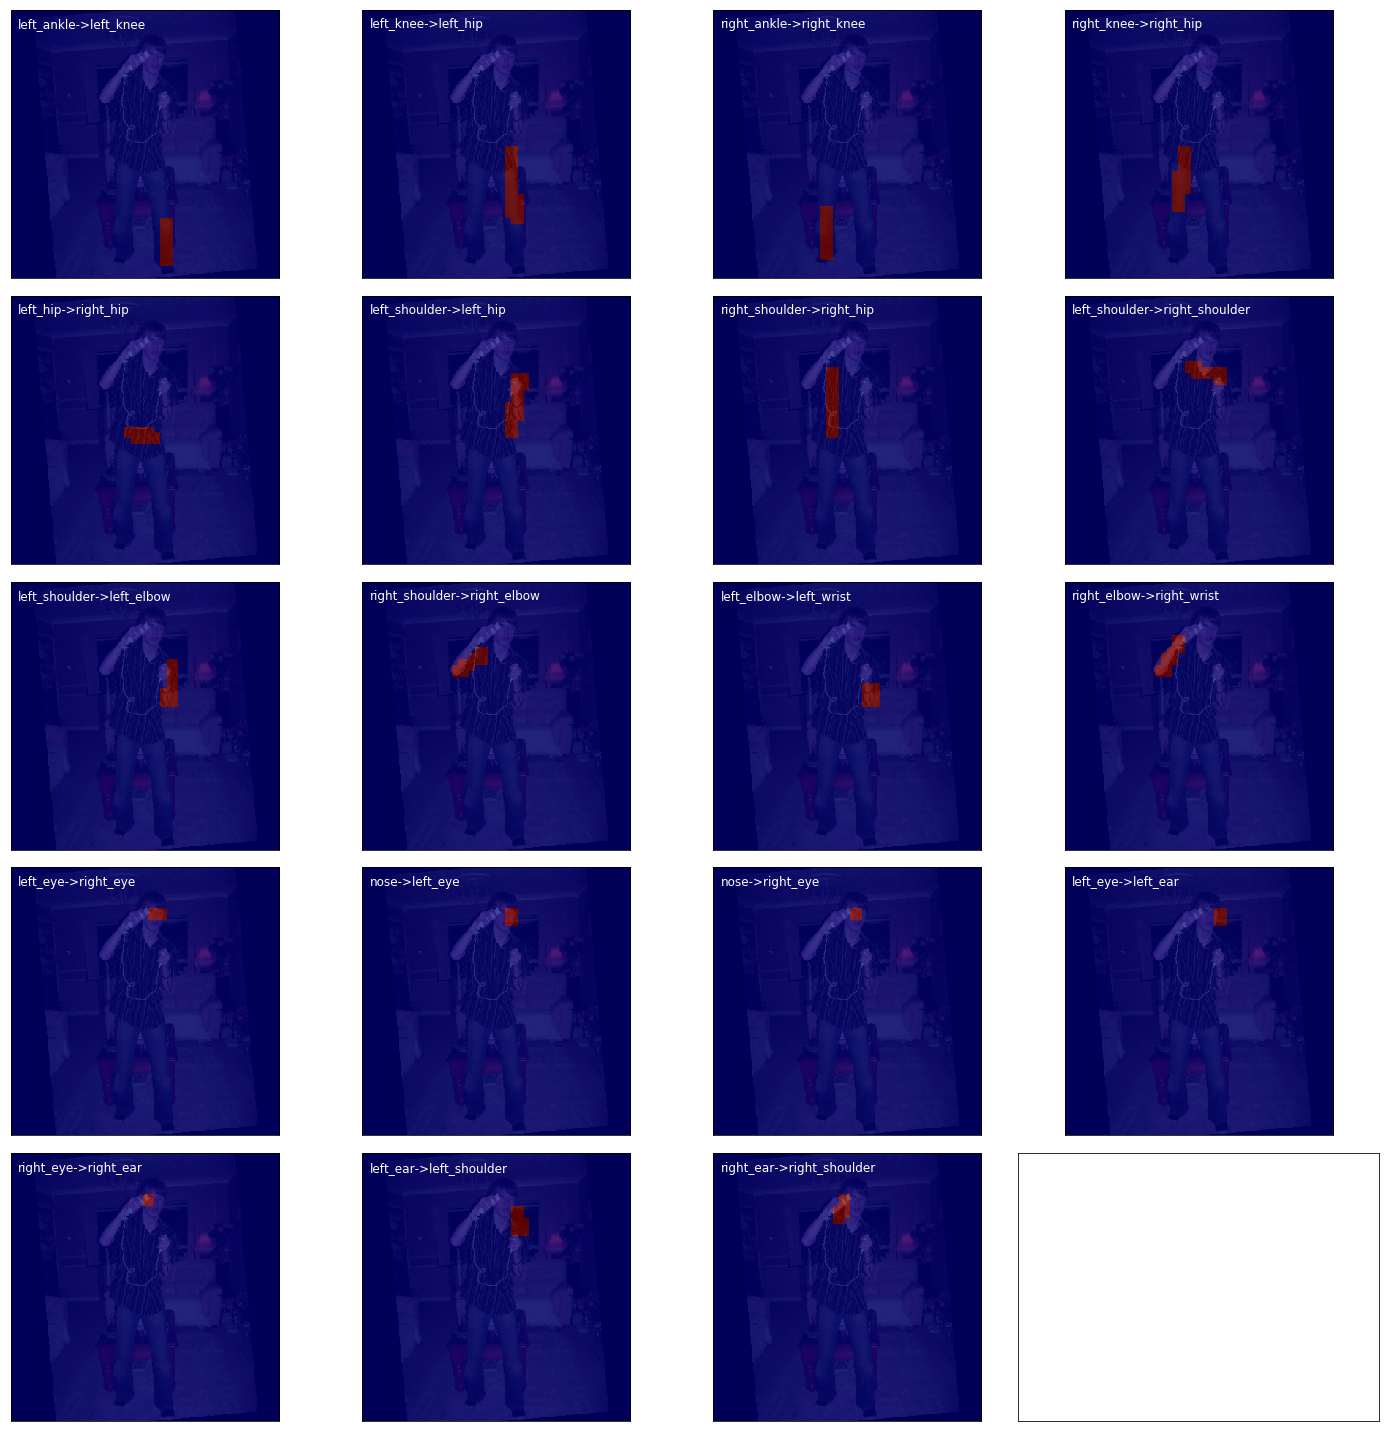

In [14]:
i,i_46x46,pafs,paf_ind,hms,hms_ind = ds[1050]
scaled_pafs = F.interpolate(pafs[None].clone().detach(), 368, mode="bilinear", align_corners=True).to(device)[0] #mode="nearest|area"
#scaled_hms = F.interpolate(hms[None].clone().detach(), 368, mode="bilinear", align_corners=True).to(device)[0]
un_im = p(un(i)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, scaled_pafs.clone().detach().cpu().numpy(), figsize=(20,20))
#plot_utils.plot_heatmaps(un_im, hms.clone().detach().cpu().numpy(), figsize=(20,20))

In [5]:
%%time 
for x,y,z,a,b,c in dl:
    break   

CPU times: user 208 ms, sys: 8 ms, total: 216 ms
Wall time: 217 ms


In [7]:
#model.freeze_F()
#model.train_paf_stage(2)
#model.freeze_all_paf_stages()
#model.train_hm_stage(2)
#model.set_to_inference()

In [6]:
model = Net(in_training=True)
model.load_state_dict(torch.load('hm-stage2-new-opt.ckpt'))

#model.set_to_inference()
model.train_paf_stage(4)
model.unfreeze_all_paf_stages()
model.unfreeze_F()
model.freeze_all_hm_stages()
model.to(device)

Net(
  (F): F(
    (vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [28]:
model.freeze_all_hm_stages()

In [25]:
model.train_paf_stage(4)
model.unfreeze_all_paf_stages()
model.unfreeze_F()

In [8]:
for p in model.Heatmap_Stages.Stage1.parameters():
    p.requires_grad = True

In [ ]:
for p in model.Heatmap_Stages.parameters():
    print(p.requires_grad)

In [8]:
model.train()
n_epochs = 1
lr = 0.0001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0

for e in range(n_epochs):
    for imgs, imgs_46x46, pafs, paf_inds, hms, hm_inds in dl:
        optimizer.zero_grad()
        
        imgs, imgs_46x46, pafs, paf_inds, hms, hm_inds = imgs.to(device), imgs_46x46.to(device), pafs.to(device), paf_inds.to(device), hms.to(device), hm_inds.to(device) 
        pred_pafs, pred_hms = model(imgs, imgs_46x46)
        loss = model_utils.paf_and_heatmap_loss(pred_pafs, pafs, paf_inds, pred_hms, hms, hm_inds)
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
        if(total_steps%250==0):
            torch.save(model.state_dict(),'hm-stage2-new-opt.ckpt')
            print('saving model')
                                                       
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

Epoch [1/1], Iteration [1/5647], Loss: 99.5160
Epoch [1/1], Iteration [10/5647], Loss: 68.6978
Epoch [1/1], Iteration [20/5647], Loss: 106.5836
Epoch [1/1], Iteration [30/5647], Loss: 107.9680
Epoch [1/1], Iteration [40/5647], Loss: 105.9403
Epoch [1/1], Iteration [50/5647], Loss: 102.7302
Epoch [1/1], Iteration [60/5647], Loss: 60.7534
Epoch [1/1], Iteration [70/5647], Loss: 79.9389
Epoch [1/1], Iteration [80/5647], Loss: 109.4575
Epoch [1/1], Iteration [90/5647], Loss: 104.0433
Epoch [1/1], Iteration [100/5647], Loss: 89.0083
Epoch [1/1], Iteration [110/5647], Loss: 96.9172
Epoch [1/1], Iteration [120/5647], Loss: 85.3913
Epoch [1/1], Iteration [130/5647], Loss: 120.7645
Epoch [1/1], Iteration [140/5647], Loss: 70.9436
Epoch [1/1], Iteration [150/5647], Loss: 92.7560
Epoch [1/1], Iteration [160/5647], Loss: 110.5023
Epoch [1/1], Iteration [170/5647], Loss: 88.7156
Epoch [1/1], Iteration [180/5647], Loss: 101.9041
Epoch [1/1], Iteration [190/5647], Loss: 95.3191
Epoch [1/1], Iteration

Epoch [1/1], Iteration [1640/5647], Loss: 96.6685
Epoch [1/1], Iteration [1650/5647], Loss: 72.4683
Epoch [1/1], Iteration [1660/5647], Loss: 107.2977
Epoch [1/1], Iteration [1670/5647], Loss: 96.4112
Epoch [1/1], Iteration [1680/5647], Loss: 114.8481
Epoch [1/1], Iteration [1690/5647], Loss: 64.5234
Epoch [1/1], Iteration [1700/5647], Loss: 114.6720
Epoch [1/1], Iteration [1710/5647], Loss: 110.4001
Epoch [1/1], Iteration [1720/5647], Loss: 122.2351
Epoch [1/1], Iteration [1730/5647], Loss: 96.4241
Epoch [1/1], Iteration [1740/5647], Loss: 87.3390
saving model
Epoch [1/1], Iteration [1750/5647], Loss: 56.8844
Epoch [1/1], Iteration [1760/5647], Loss: 89.4050
Epoch [1/1], Iteration [1770/5647], Loss: 103.3949
Epoch [1/1], Iteration [1780/5647], Loss: 127.6692
Epoch [1/1], Iteration [1790/5647], Loss: 101.5101
Epoch [1/1], Iteration [1800/5647], Loss: 93.9779
Epoch [1/1], Iteration [1810/5647], Loss: 88.7858
Epoch [1/1], Iteration [1820/5647], Loss: 79.8238
Epoch [1/1], Iteration [1830/

saving model
Epoch [1/1], Iteration [3250/5647], Loss: 115.8353
Epoch [1/1], Iteration [3260/5647], Loss: 87.0890
Epoch [1/1], Iteration [3270/5647], Loss: 83.6272
Epoch [1/1], Iteration [3280/5647], Loss: 84.7819
Epoch [1/1], Iteration [3290/5647], Loss: 91.2654
Epoch [1/1], Iteration [3300/5647], Loss: 98.7734
Epoch [1/1], Iteration [3310/5647], Loss: 85.1630
Epoch [1/1], Iteration [3320/5647], Loss: 63.6288
Epoch [1/1], Iteration [3330/5647], Loss: 85.3911
Epoch [1/1], Iteration [3340/5647], Loss: 108.2938
Epoch [1/1], Iteration [3350/5647], Loss: 83.6160
Epoch [1/1], Iteration [3360/5647], Loss: 122.4808
Epoch [1/1], Iteration [3370/5647], Loss: 114.9512
Epoch [1/1], Iteration [3380/5647], Loss: 145.3779
Epoch [1/1], Iteration [3390/5647], Loss: 76.4888
Epoch [1/1], Iteration [3400/5647], Loss: 127.5836
Epoch [1/1], Iteration [3410/5647], Loss: 119.9336
Epoch [1/1], Iteration [3420/5647], Loss: 104.9998
Epoch [1/1], Iteration [3430/5647], Loss: 60.4758
Epoch [1/1], Iteration [3440/

Epoch [1/1], Iteration [4860/5647], Loss: 94.4381
Epoch [1/1], Iteration [4870/5647], Loss: 113.4327
Epoch [1/1], Iteration [4880/5647], Loss: 95.6348
Epoch [1/1], Iteration [4890/5647], Loss: 94.4868
Epoch [1/1], Iteration [4900/5647], Loss: 75.6736
Epoch [1/1], Iteration [4910/5647], Loss: 95.4426
Epoch [1/1], Iteration [4920/5647], Loss: 69.8690
Epoch [1/1], Iteration [4930/5647], Loss: 126.3303
Epoch [1/1], Iteration [4940/5647], Loss: 87.8040
Epoch [1/1], Iteration [4950/5647], Loss: 89.2061
Epoch [1/1], Iteration [4960/5647], Loss: 106.5335
Epoch [1/1], Iteration [4970/5647], Loss: 113.3136
Epoch [1/1], Iteration [4980/5647], Loss: 96.4633
Epoch [1/1], Iteration [4990/5647], Loss: 76.8571
saving model
Epoch [1/1], Iteration [5000/5647], Loss: 96.2086
Epoch [1/1], Iteration [5010/5647], Loss: 83.2607
Epoch [1/1], Iteration [5020/5647], Loss: 94.1437
Epoch [1/1], Iteration [5030/5647], Loss: 95.2009
Epoch [1/1], Iteration [5040/5647], Loss: 83.4313
Epoch [1/1], Iteration [5050/5647

In [ ]:
#torch.save(model.state_dict(),'stage1-trained.ckpt')

In [23]:
%%time
with torch.no_grad():
    model.eval()
    model.set_to_inference()
    imgs,imgs_46x46, _, _, _, _ = iter(dl).next()
    pred_pafs_stages, pred_hms_stages = model(imgs.to(device), imgs_46x46.to(device))
    scaled_pafs = F.interpolate(pred_pafs_stages.clone().detach(), 368, mode="bilinear", align_corners=True).to(device)
    scaled_hms = F.interpolate(pred_hms_stages.clone().detach(), 368, mode="bilinear", align_corners=True).to(device)

CPU times: user 236 ms, sys: 24 ms, total: 260 ms
Wall time: 245 ms


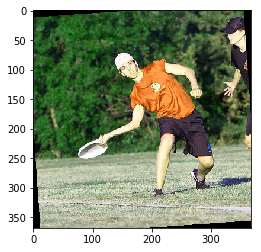

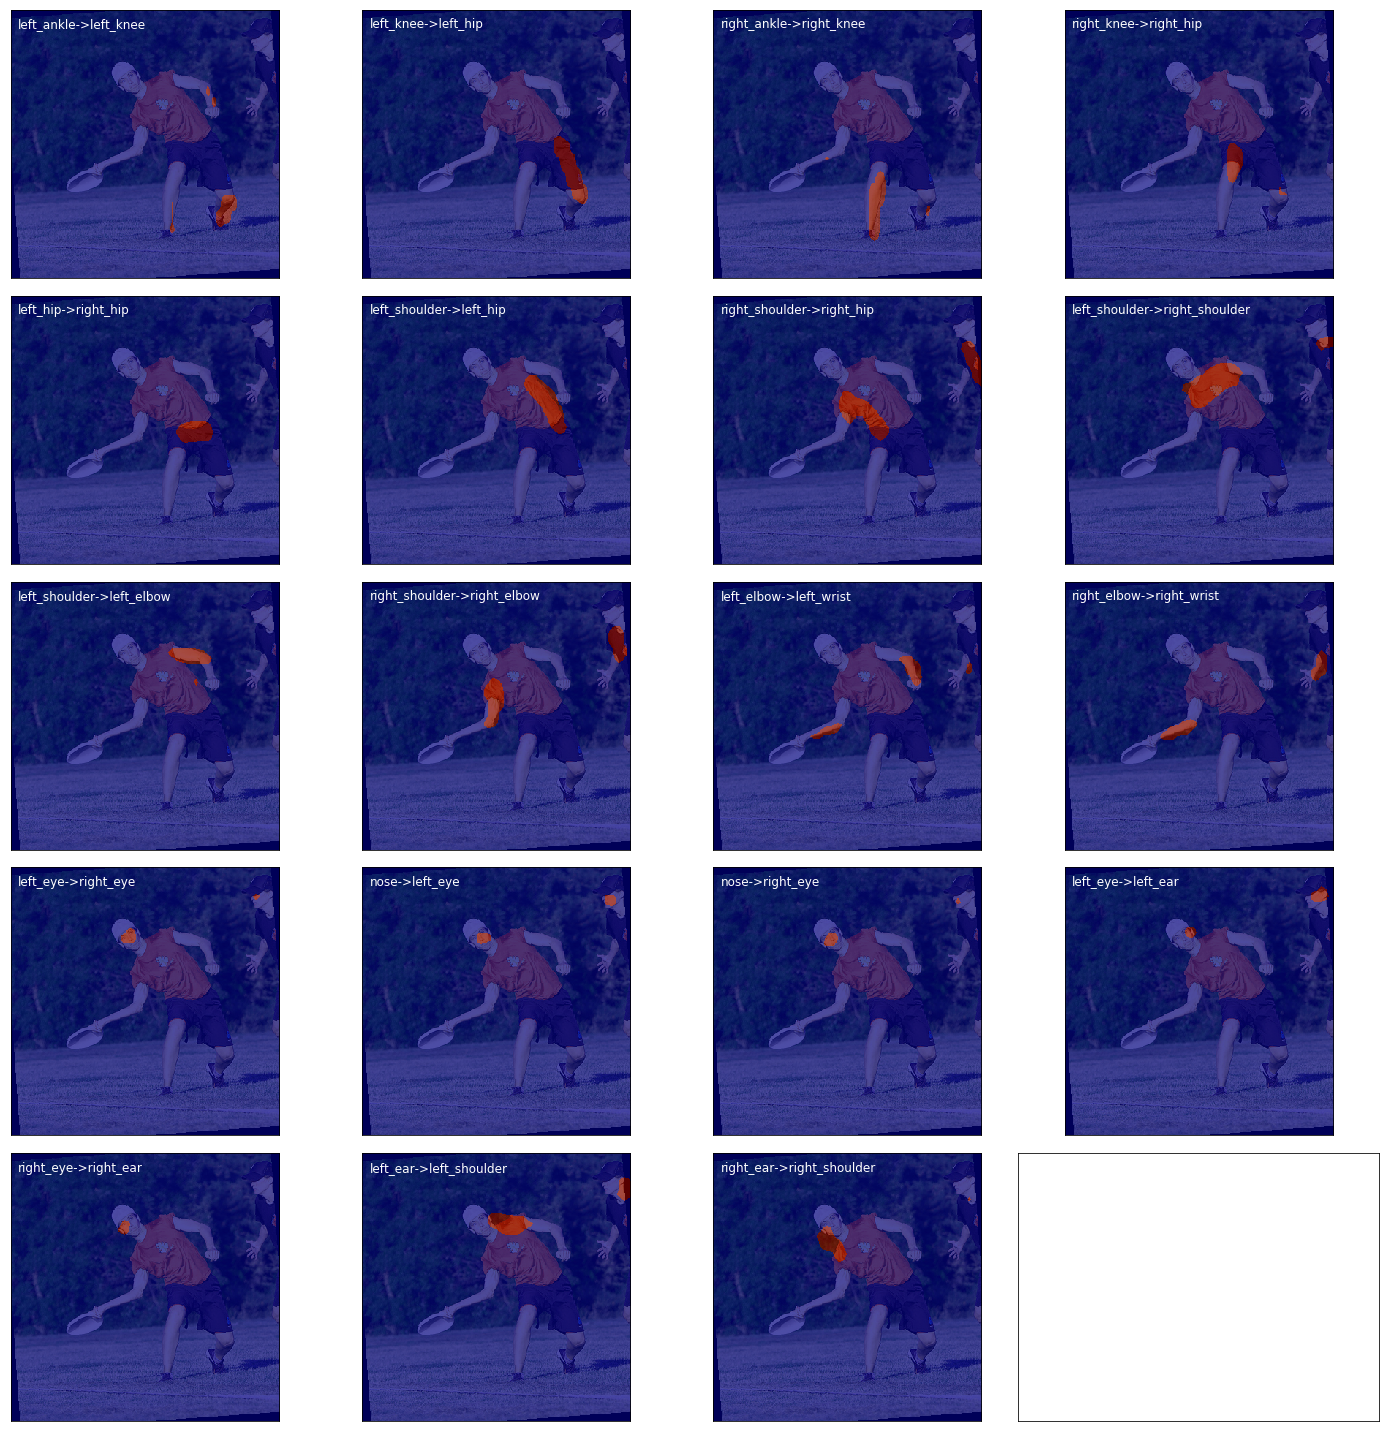

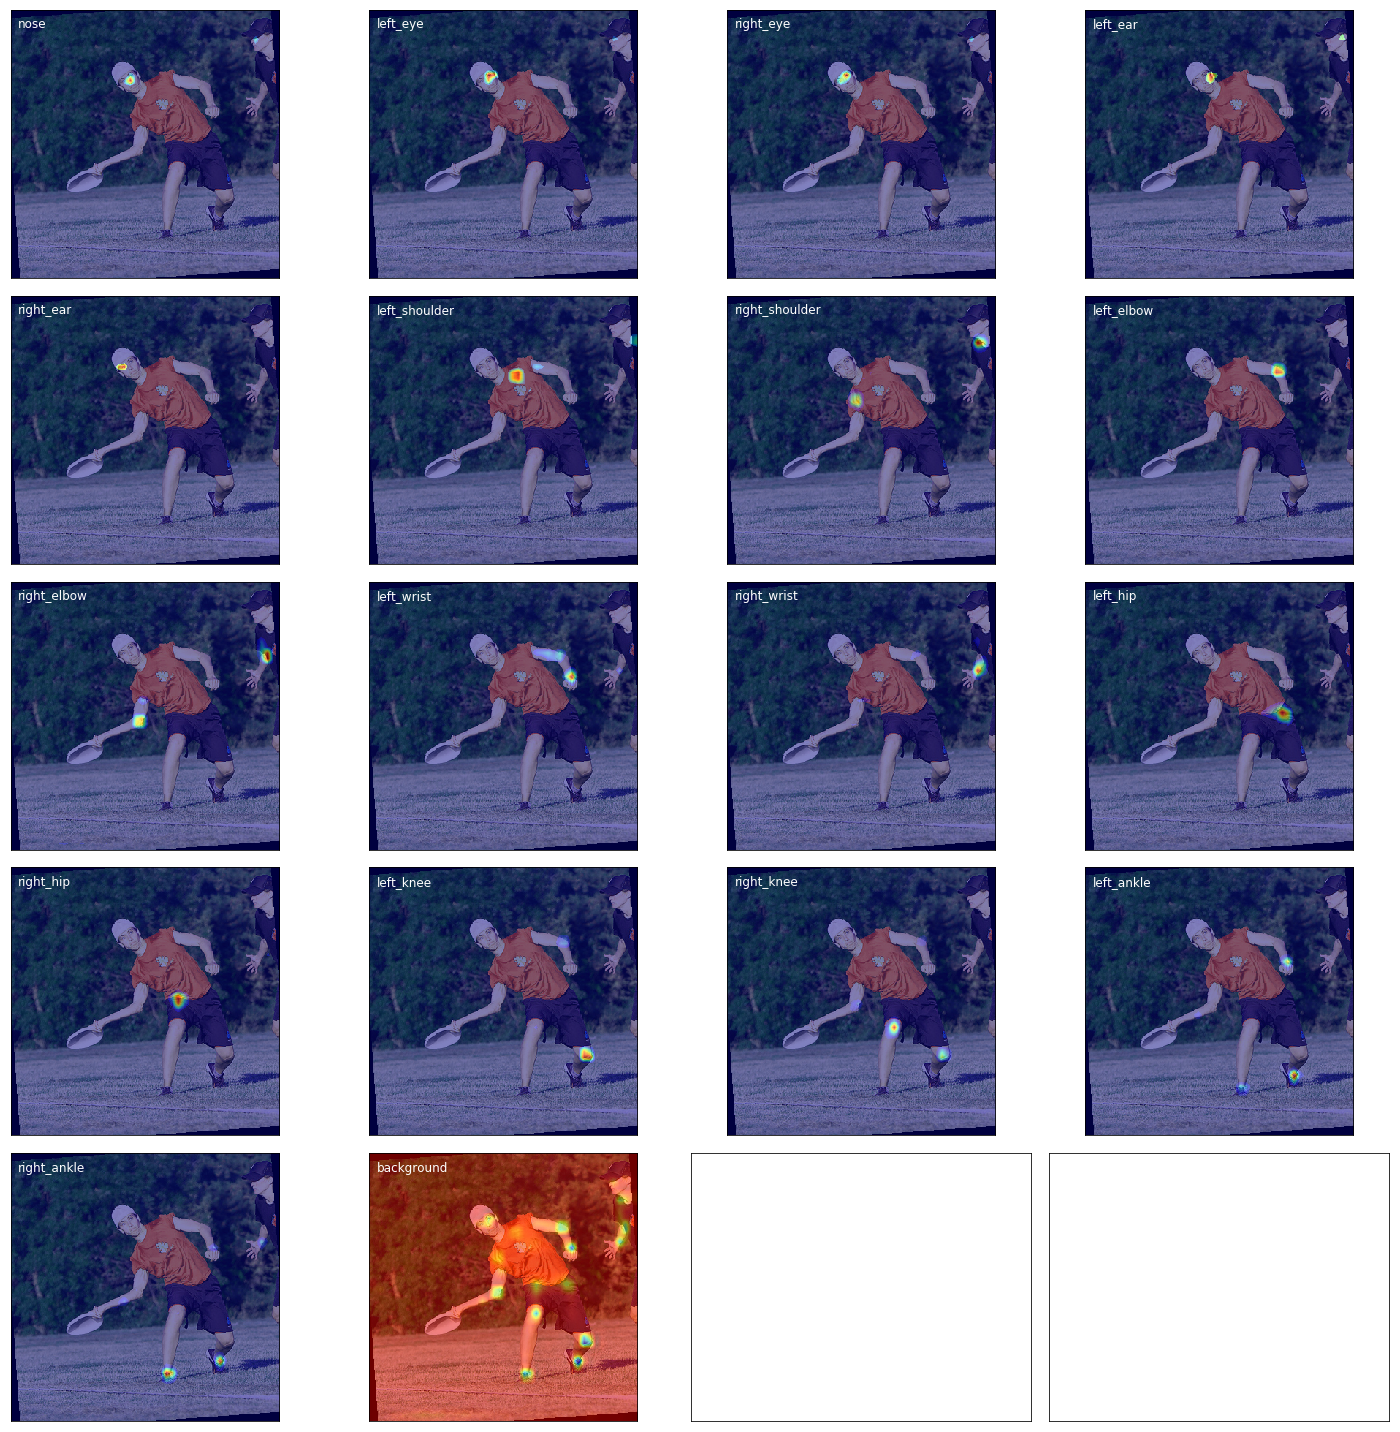

In [32]:
idx = 2
im = imgs[idx]
pf = scaled_pafs[idx].clone()
hm = scaled_hms[idx].clone()
pf[torch.abs(pf)<1e-1] = 0
hm[torch.abs(hm)<1e-1] = 0

un_im = To_Pil(un(im)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, pf.cpu().numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hm.cpu().numpy(), figsize=(20,20))

In [8]:
test_tensor_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
R_368x368 = Resize(368)
R_46x46 = transforms.Resize(46)

test_img_368x368 = R_368x368(Image.open('./test-2.png'))
test_img_46x46 = R_46x46(test_img_368x368)

im = test_tensor_tfms(test_img_368x368)[:3]
im_46x46 = test_tensor_tfms(test_img_46x46)[:3]

In [9]:
with torch.no_grad():
    model.eval()
    pred_pafs_stages, pred_hms_stages = model(im[None].to(device), im_46x46[None].to(device))
    scaled_pafs = F.interpolate(pred_pafs_stages, 368, mode="bilinear", align_corners=True).to(device)
    scaled_hms = F.interpolate(pred_hms_stages, 368, mode="bilinear", align_corners=True).to(device)

In [11]:
idx = 0
im = imgs[idx]
pf = scaled_pafs[idx].clone()
hm = scaled_hms[idx].clone()
pf[torch.abs(pf)<1e-1] = 0
hm[torch.abs(hm)<1e-1] = 0

un_im = p(un(im)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, pf.numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hm.numpy(), figsize=(20,20))

TypeError: 'Parameter' object is not callable

In [ ]:
i,i_46x46,pafs,paf_ind,hms,hms_ind = ds[1000]
un_im = p(un(i)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, pafs.numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hms.numpy(), figsize=(20,20))

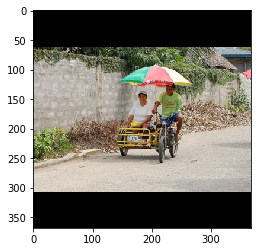

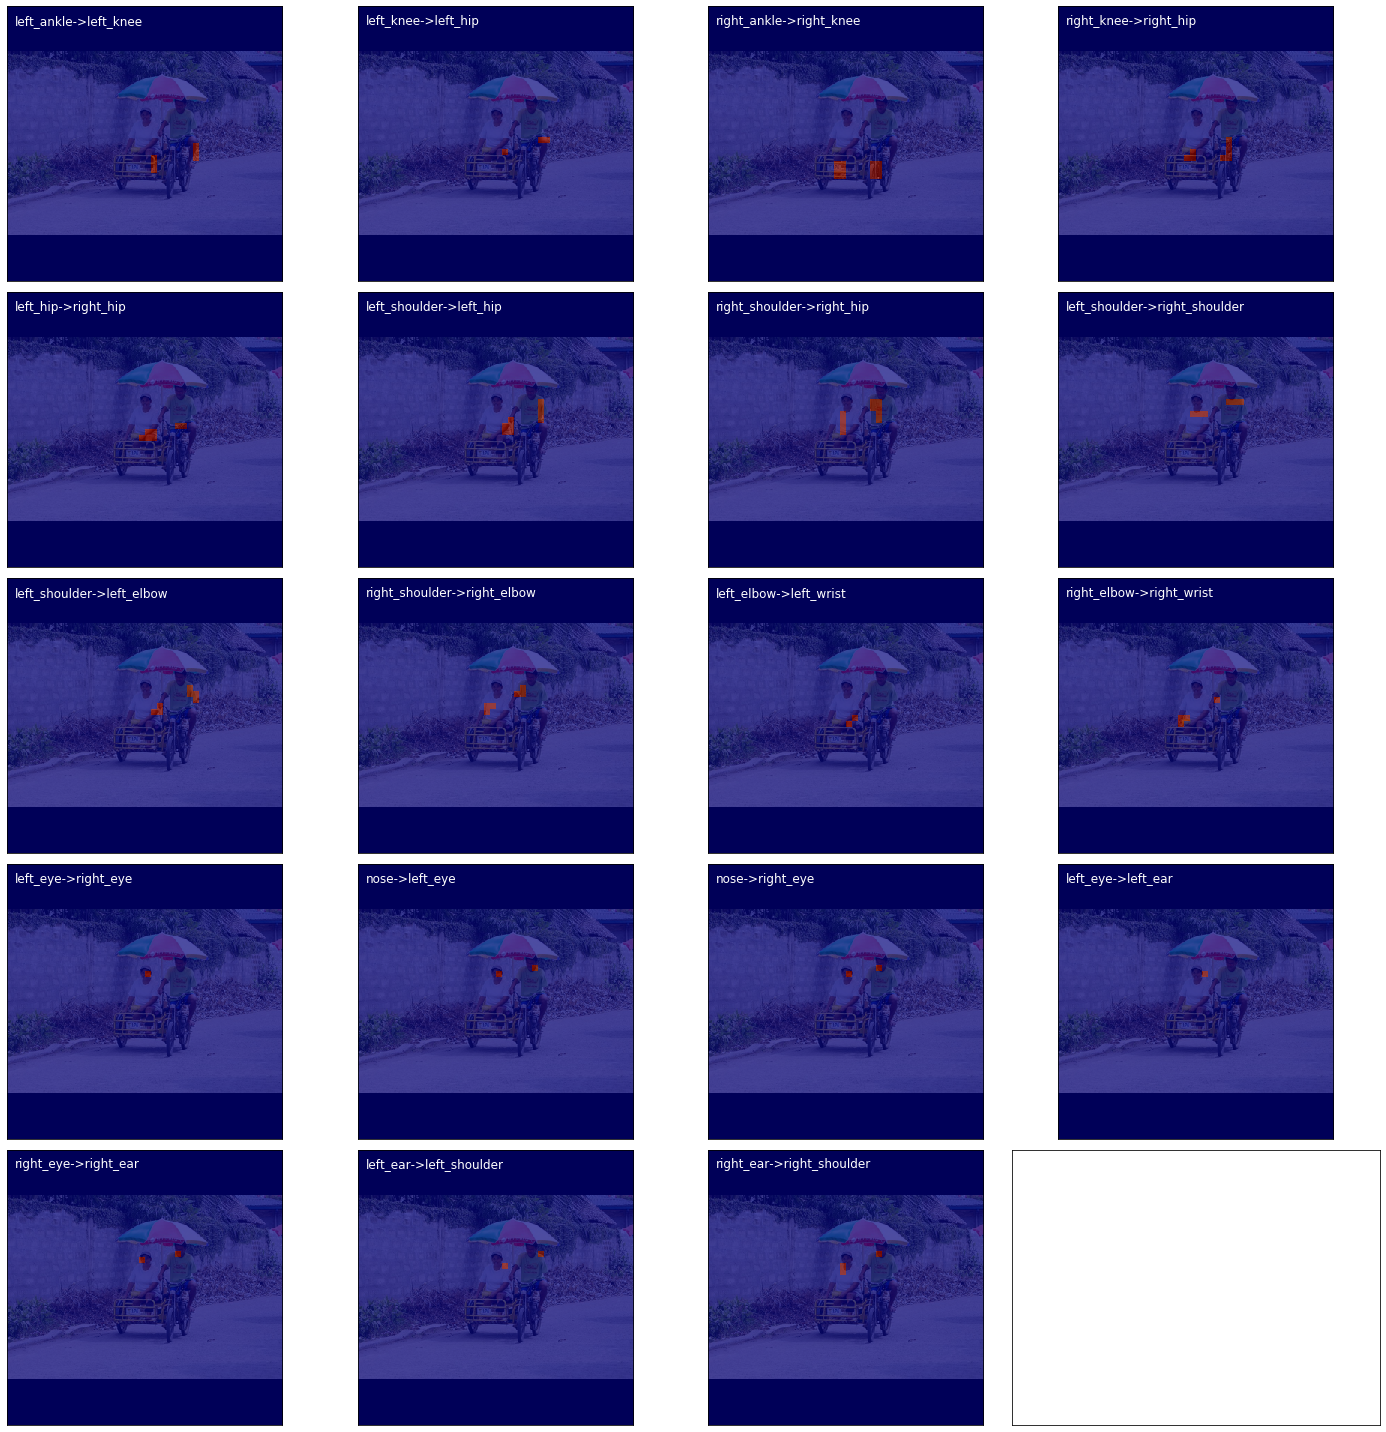

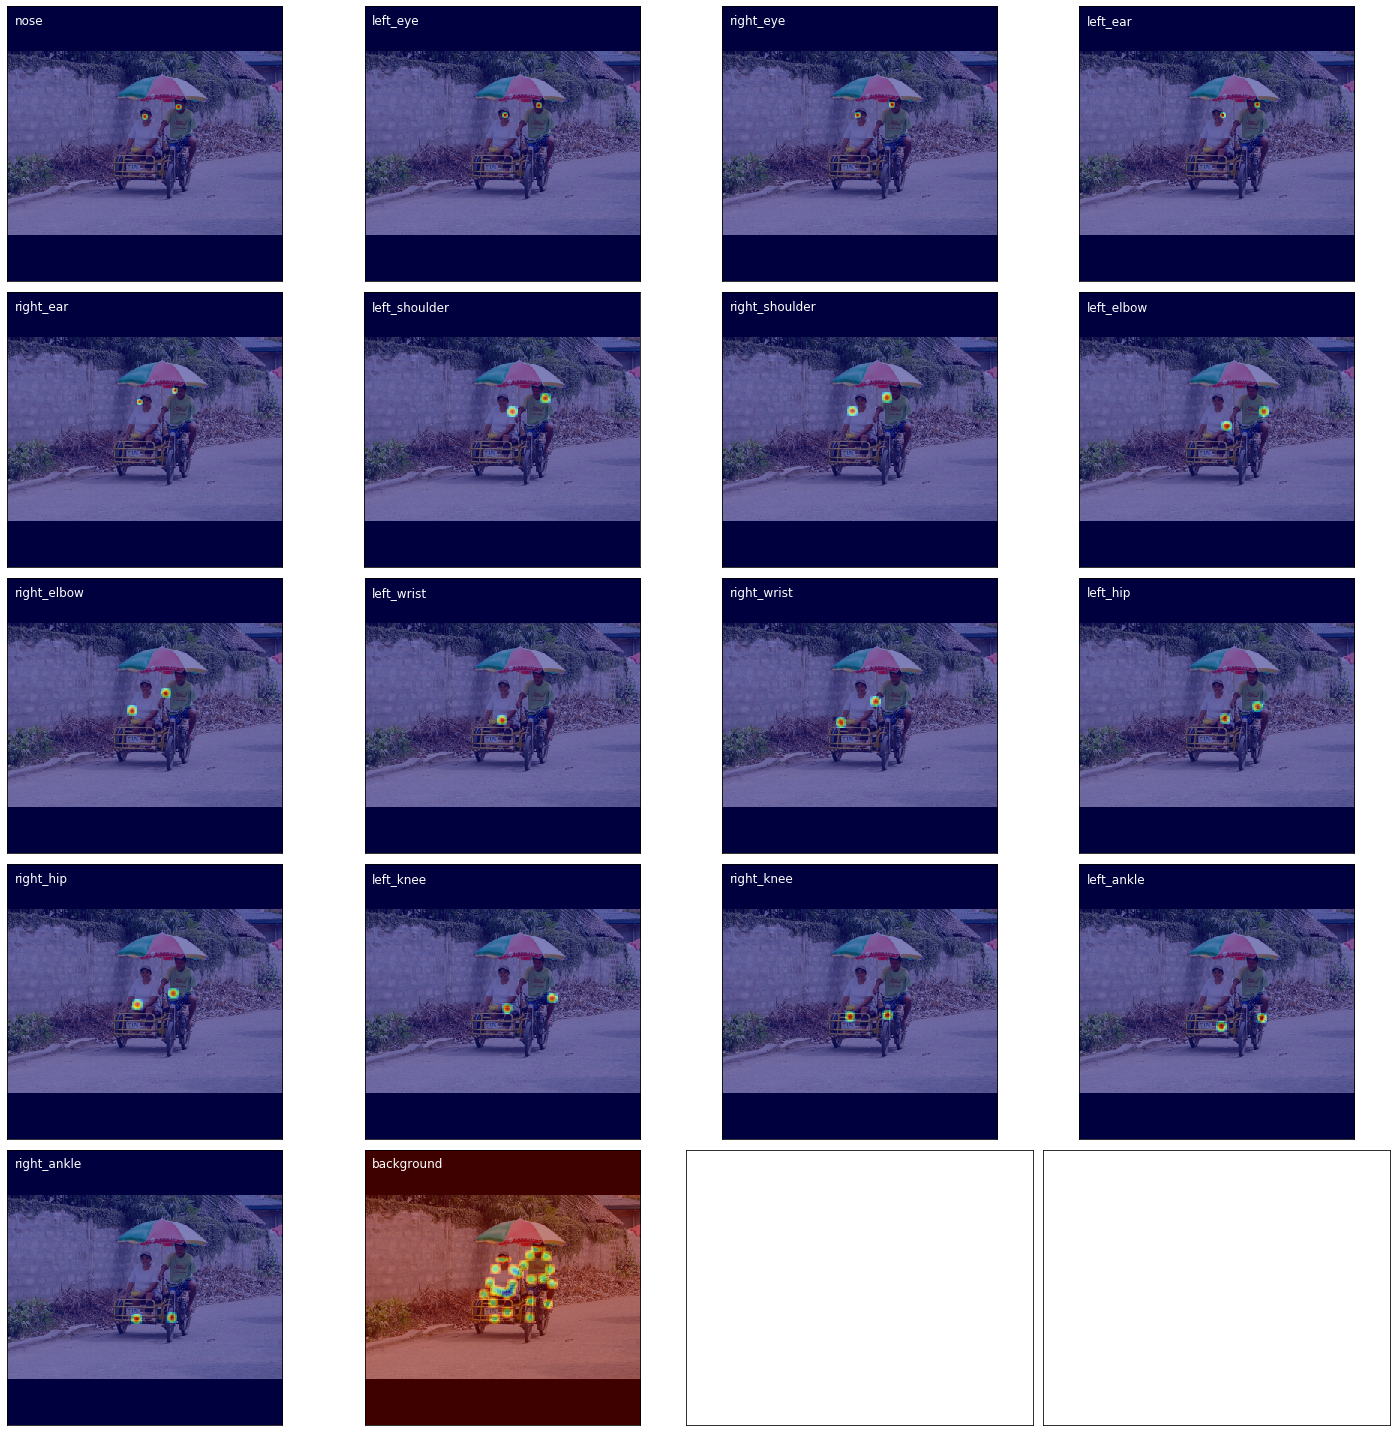

In [6]:
i,i_46x46,pafs,paf_ind,hms,hms_ind = ds[0]
scaled_pafs = F.interpolate(pafs[None].clone().detach(), 368, mode="nearest").to(device)[0] #mode="nearest|area"
#scaled_hms = F.interpolate(hms[None].clone().detach(), 368, mode="bilinear", align_corners=True).to(device)[0]
un_im = p(un(i)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, scaled_pafs.numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hms.numpy(), figsize=(20,20))